This is a guided project by DataQuest ([link](https://www.dataquest.io/m/217/guided-project%3A-analyzing-nyc-high-school-data)). This is only an exploratory analysis, and any suggestions or views expressed here is not statistically supported.

There are two parts in this project.

My own code starts at [2. Code by myself](http://localhost:8888/notebooks/Schools.ipynb#2.-Code-by-myself), written according to DataQuests' guide.

The preceding part ([1. Code by DataQuest team](#1.-Code-by-DataQuest-team)) consists of code written by DataQuest team. These correspond to three missions which precedes this project (`Step 2: Data Analysis and Visualization` --> [4. Data Cleaning](https://www.dataquest.io/course/data-exploration) --> missions [1](https://www.dataquest.io/m/136/data-cleaning-walkthrough), [2](https://www.dataquest.io/m/137/data-cleaning-walkthrough%3A-combining-the-data), [3](https://www.dataquest.io/m/138/data-cleaning-walkthrough%3A-analyzing-and-visualizing-the-data)).

For both parts, the following datasets are used.

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school



# 1. Code by DataQuest team

# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/home/gknam/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/gknam/Software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# 2. Code by myself

# Safety and SAT results

Number of data points in the plot: 363
R value: 0.338


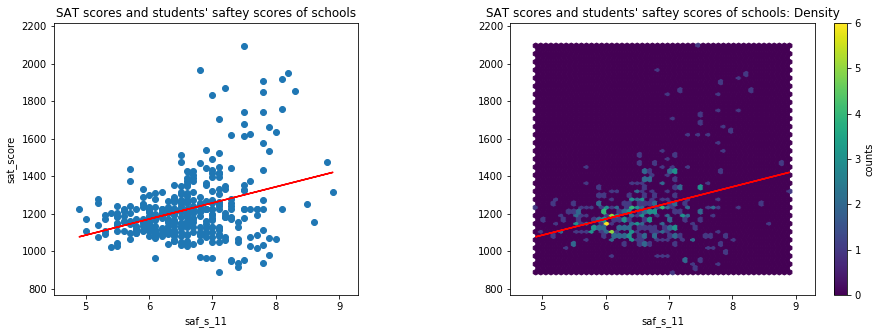

In [10]:
import matplotlib.pyplot as plt

def scatterAndFit(xCol, yCol, title, xCol_axParam=None, yCol_axParam=None, df=combined):
    """
    df: data frame containing all data
    xCol and yCol: columns in data frame
    title: title for plot
    
    Draws scatter plot and regression line using
    df's xCol and yCol columns.
    
    Also, get R value (pearson's correlation coeffcient) between
    xCol and yCol.
    
    """
    def drawRegressionLine(x):
        fit = numpy.polyfit(x=x, y=df[yCol], deg=1)
        plt.plot(x, fit[0] * x + fit[1], color='red', label="r = " + str(corr))
    
    print("Number of data points in the plot: " + str(df.shape[0]))
    
    # 0. get min, max and leeway values of xCol and yCol
    x = df[xCol]
    y = df[yCol]
    
    xCol_min, xCol_max, xCol_lw = getMinMaxLeeway(x) \
    if xCol_axParam is None\
    else xCol_axParam
    
    yCol_min, yCol_max, yCol_lw = getMinMaxLeeway(y) \
    if yCol_axParam is None\
    else yCol_axParam

    # 1. print correlations between xCol and yCol
    corr_all = df.corr()
    corr = round(corr_all[yCol][xCol], 3)
    print("R value: " + str(corr))
    
    # 2. draw scatter and hexbin plots of xCol and yCol
    # and regression lines
    fig = plt.figure(figsize=(15, 5))
    
    for i in range(2, 0, -1):
        ax = fig.add_subplot(1, 2, i)
        if i == 1:
            # draw scatter plot
            ax.scatter(x, y)

            # put title and y-axis label
            ax.set_title(title)
            ax.set_ylabel(yCol)
        else:
            # draw hexbin
            hb = ax.hexbin(x, y, gridsize=50, mincnt=None)
            
            # put title
            ax.set_title(title + ": Density")
            
        # put color bar and title (referred to http://bit.ly/2j1SvZK)
        cb = fig.colorbar(hb, ax=ax)
        
        if i == 1:
            cb.remove()
        else:
            cb.set_label("counts")

        # set ranges for x and y axes
        ax.set_xlim(left=xCol_min-xCol_lw, right=xCol_max+xCol_lw)
        ax.set_ylim(bottom=yCol_min-yCol_lw, top=yCol_max+yCol_lw)
        
        # put x-axis label
        ax.set_xlabel(xCol)
        
        drawRegressionLine(x)

    # 4. display plot
    plt.show()

def getMinMaxLeeway(series):
    """
    series: pandas series object
    
    Returns max, min values of series, and leeway value
    which is 10 percent of the series range.
    Leeway is for the axis limits in case the series
    is plotted.
    """
    
    # get minimum, maximum and leeway values of series
    s_min = series.min()
    s_max = series.max()
    s_lw = (s_max - s_min) / 10
    
    return (s_min, s_max, s_lw)

# draw plot
scatterAndFit("saf_s_11", "sat_score", "SAT scores and students' saftey scores of schools")

A rough trend of positive correlation is observed, although the spread of SAT scores increase with higher saftety scores by students. Density seems more or less evenly spread out.

Let's draw box plots to confirm this.

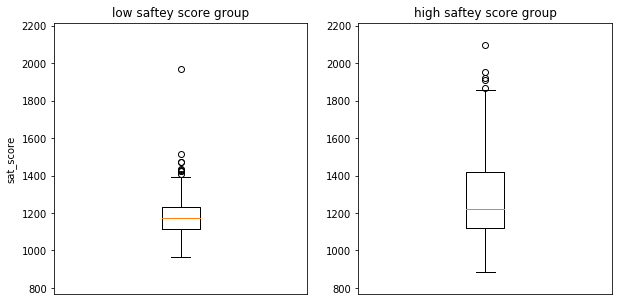

In [11]:
def divideUpperLower(df, series):
    """
    df: data frame
    series: pandas series object
    
    Returns upper and lower halves of series.
    """
    
    s_mid = (series.max() + series.min()) / 2

    s_hi = df[series >= s_mid]
    s_lo = df[series < s_mid]
    
    return (s_hi, s_lo)

    
def divideAndBoxplot(df, var_div, var_box, var_div_title):
    """
    df: data frame
    var_div: a column in data frame, by which
            the data frame will be divided into
            high and low groups by this variable
    var_div_title: subplot titles
    var_box: a column in data frame, which
            will be displayed in box plots
    """

    # read in saftety and SAT scores
    div = df[var_div]
    box = df[var_box]
    
    # get min, max and leeway of var_box
    box_min, box_max, box_lw = getMinMaxLeeway(box)

    # split data into groups of low and hi safety scores
    div_hi, div_lo = divideUpperLower(df, div)
    
    div_titles = ["low " + var_div_title + " group", "high " + var_div_title + " group"]

    # create figure
    fig = plt.figure(figsize=(10, 5))
    
    for i, var in enumerate([div_lo, div_hi], 1):
        ax = fig.add_subplot(1, 2, i)
        ax.boxplot(var[var_box])
        ax.set_ylim(bottom=box_min-box_lw, top=box_max+box_lw)
        ax.tick_params(bottom="off")
        ax.set_xticks([])
        ax.set_title(div_titles[i - 1])
        
        if i == 1:
            ax.set_ylabel(var_box)
    
    # show figure
    plt.show()

# draw box plot
divideAndBoxplot(combined, "saf_s_11", "sat_score", "saftey score")

Yes, high safety score score group shows more diverse SAT scores.

This may reflect that (1) students naturally perform at various levels at SAT, but (2) they all get downgraded when constantly sensing danger in the environment.

Where are these areas, then? Let's see.

/home/gknam/Software/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/gknam/Software/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/gknam/Software/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/gknam/Software/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


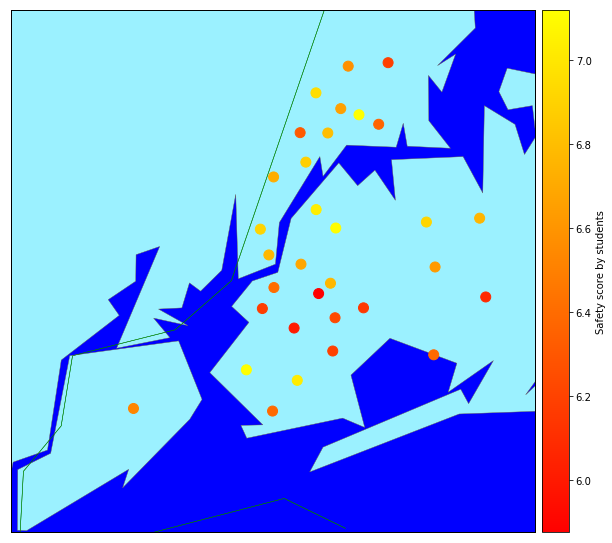

In [12]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1. get average safety score fore each district
combined_byDist = combined.groupby("school_dist").agg(numpy.mean)
combined_byDist.reset_index(inplace=True)

# 2. show safety scores on map

def showOnMap(df, var, var_label, spectrum="continuous"):
    """
    var: variable of interest
    lon: longitude of district
    lat: latitude of district

    Show var in color spectrum at coordinates
    specified by lon and lat.
    """

    if spectrum not in {"continuous", "dichotomous"}:
        print("spectrum should be either 'continuous' or 'dichotomous'.")
        return
    
    # get coordinates
    lon = df["lon"].tolist()
    lat = df["lat"].tolist()

    # create Basemap constructor
    fig, ax = plt.subplots(figsize=(10, 10))
    m = Basemap(projection="merc", llcrnrlon=-74.255735, llcrnrlat=40.496044, \
                urcrnrlon=-73.700272, urcrnrlat=40.915256, resolution="i")

    # draw details and fill with color
    m.drawmapboundary(fill_color="blue")
    m.drawstates(color="green")
    m.fillcontinents(color="#9bf1ff")
    m.drawcoastlines(color="#6D5F47", linewidth=.4)
    m.drawrivers(color="#6D5F47", linewidth=.4)

    # draw scatter plot
    if spectrum == "continuous":
        cmap = "autumn"
    elif spectrum == "dichotomous":
        cmap = "seismic"
    
    m_scatter = m.scatter(x=lon, y=lat, latlon=True, s=100, zorder=2, c=df[var], cmap=cmap)

    # put color bar and its title (source https://stackoverflow.com/a/18195921)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = fig.colorbar(m_scatter, cax=cax)
    cb.set_label(var_label)

    # adjust and show plot
    plt.show()

showOnMap(combined_byDist, "saf_s_11", "Safety score by students")

Some of the most dangerous areas as perceived by students are in middle and North of Brooklyn and East of Queens. The perceivedly safest areas are middle and West of Brooklyn, West of Queens, and South West of Bronx.

# Race and SAT scores

Data indicates proportion of different races at each school (white, black, asian and hispanic). Difference in their correlation with SAT scores would indicate that some races are doing better than the others. So, let's see which group is doing how well.

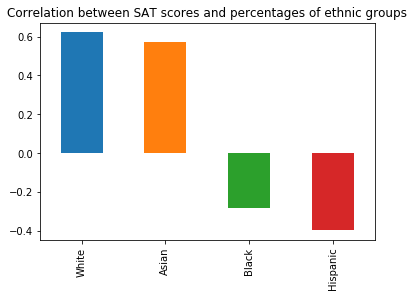

In [13]:
def drawBarPlot(series, indices, indices_labels, title, sort=True):
    """
    series: pandas series
    indices: indices in series
    indices_labels: labels of indices.
        These will be tick labels in x axis.
    
    Draws bar plots of indices
    """

    # extract data from indices of series
    series = series[indices]
    
    # sort extracted data if eligible
    if sort:
        series = series.sort_values(ascending=False)

    # draw and display plot
    ax = series.plot.bar()
    
    # put x tick labels
    ind_lab_map = {}
    for i, v in enumerate(indices):
        ind_lab_map[v] = indices_labels[i]

    indices = [i.get_text() for i in ax.get_xticklabels()]
    indices_labels = []
    for i in indices:
        indices_labels.append(ind_lab_map[i])

    ax.set_xticklabels(indices_labels)
    
    # put title
    ax.set_title(title)
    
    # display plot
    plt.show()

drawBarPlot(correlations, ["white_per", "black_per", "asian_per", "hispanic_per"], \
["White", "Black", "Asian", "Hispanic"], "Correlation between SAT scores and \
percentages of ethnic groups")

So, presence of more white and Asian students means higher SAT scores. On the contrary, more black and hispanic students were associated with lower SAT scores.

What's the story with the hispanic group? Let's scatter plot SAT scores agains their proportion.

Number of data points in the plot: 363
R value: -0.397


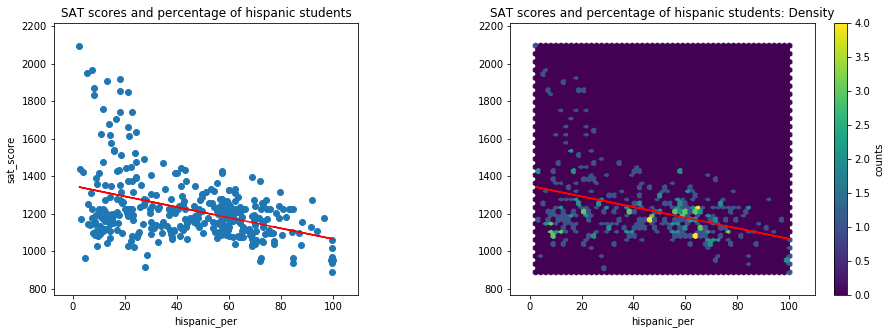

In [14]:
scatterAndFit("hispanic_per", "sat_score", "SAT scores and percentage of hispanic students")
plt.show()

The spread is narrower with higher hispanic proportion, also demonstrated by following box plots. Density map appears largely even in all areas, with slightly more schools with hispanic proportion between about 45-65% and SAT scores between around 1050-1300.

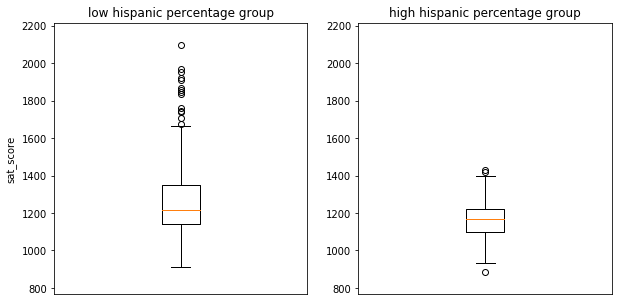

In [15]:
divideAndBoxplot(combined, "hispanic_per", "sat_score", "hispanic percentage")

So, the negative association between hispanic presence and SAT scores seems to get stronger as the hispanic presence increases.

Let's then look at the schools with the highest proportion (> 95%)of hispanic students.

Percentage of English language students have been checked following DataQuest's [solution](https://github.com/dataquestio/solutions/blob/master/Mission217Solutions.ipynb). 

In [16]:
def filterCols(conds, vars_disp, df=combined):
    """
    df: data frame
    conds: conditions to filter df with.
            a list of Pandas series objects.
    vars_disp: variables to display in filtered df.
                A column name or a list of column name.
    """
    # get subset of data where conditions are satisfied
    df_filt = df[:]
    if type(conds) == list:
        for c in conds:
            df_filt = df_filt[c]
    else:
        df_filt = df_filt[conds]

    # disply var_disp1 and var_disp2
    display(df_filt[vars_disp])
    

filterCols(combined["hispanic_per"] > 95, "SchoolName")

44             Manhattan Bridges High School
82                                         0
89            GREGORIO LUPERON HS SCI & MATH
125      Academy for Language and Technology
141    International School for Liberal Arts
176                                        0
253                Multicultural High School
286                                        0
Name: SchoolName, dtype: object

The percentage of English learners tended to be very high in these schools.

Then, what about the schools with least hispanic students (< 10%) with very high SAT scores (> 1800)?

<a name="hispMin_satHigh"></a>

In [17]:
# get subset of data where hispanic percentage is < 10% and
# SAT score is > 1800
filterCols([combined["hispanic_per"] < 10, combined["sat_score"] > 1800], ["SchoolName", "ell_percent"])

/home/gknam/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


,SchoolName,ell_percent
37,STUYVESANT HS,0.0
151,BRONX HS OF SCIENCE,0.1
187,BROOKLYN TECHNICAL HS,0.1
327,Queens HS for Science York Colllege,0.2
356,STATEN ISLAND TECHNICAL HS,0.1


Consistently, these schools have very small proportion of English learners.

This suggests that the strong negative correlation between hispanic presence and SAT scores may be due to the high proportion of English language learners in those schools. So, let's check the correlation between SAT scores and percentage of English learners.

Number of data points in the plot: 363
R value: -0.399


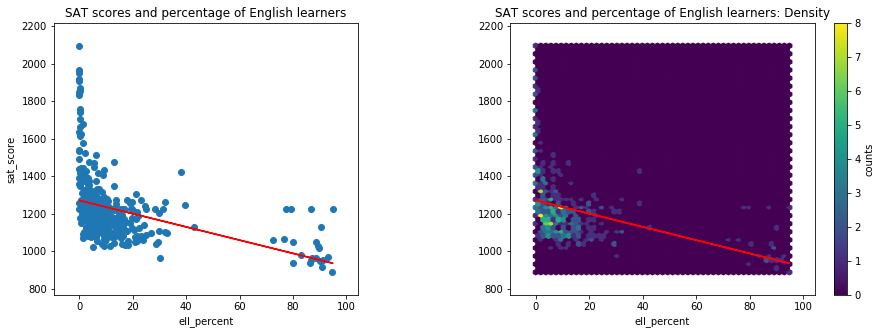

In [18]:
# scatter plot SAT scores against English learners' proportion
scatterAndFit("ell_percent", "sat_score", "SAT scores and percentage of English learners")
plt.show()

The correlation is marginally stronger than that between proportion of hispanic students and SAT scores.

Then, perhaps hispanic and English learners' proportions are correlated, too? Let's see.

Number of data points in the plot: 363
R value: 0.403


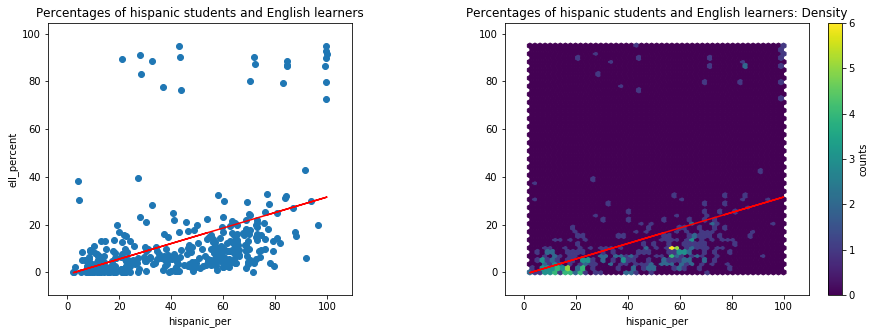

In [19]:
scatterAndFit("hispanic_per", "ell_percent", "Percentages of hispanic students and English learners")

<a name="race_sat_closing"></a>

Yes, they are.

But, what do these mean? The results do not prove which variable affects SAT score more although intuition suggests that English learners would struggle more at SAT tests. So, the proportion of English learners is perhaps a more significant variable to consider than the hispanic proportion?

Fluency in English, however, is not enough to achieve high SAT scores. Consistent with this question is the fact that the above-listed [top schools with little hispanic presence and high SAT scores](hispMin_satHigh) are all highly selective and specialised schools - i.e. they are elite schools. Therefore, the type of schools probably matter more when it comes to SAT scores than does percentages of English learners or the proportion of a particular racial group.

This probably opens up other issues of why certain races are less prevelant in these top schools, which is beyond the scope of this project.

# Gender and SAT scores

Now, let's go into the ever-popular area of which gender does how well.

First, let's how SAT scores are associated with each gender's percentage.

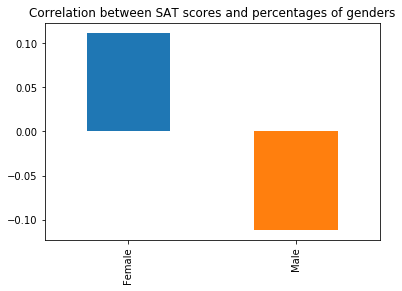

In [20]:
drawBarPlot(correlations, ["male_per", "female_per"], ["Male", "Female"], \
"Correlation between SAT scores and percentages of genders")

The data shows that more female students' presence means higher SAT scores although the correlation is not strong.

The focus is now on female students, whose proportion will be scatter plotted with SAT scores.

Number of data points in the plot: 363
R value: 0.112


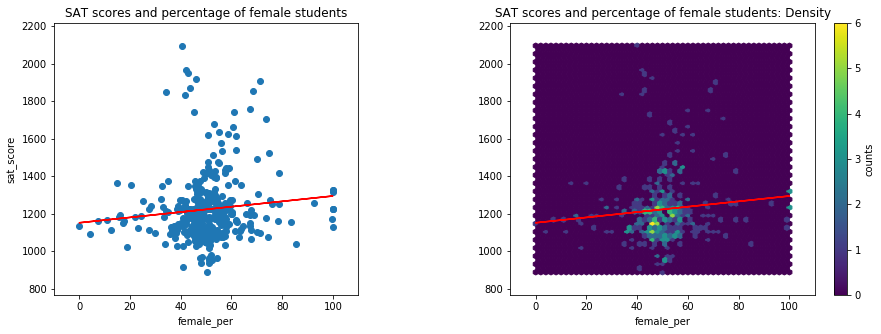

In [21]:
scatterAndFit("female_per", "sat_score", "SAT scores and percentage of female students")

Most observations are at mid-female percentage and low-to-middle SAT score groups.

Generally, high-scoring groups were from schools with mid-female percentage, while low-scoring schools had the whole range of female proportions from low to high. This spread is apparent in the following box plots as well.

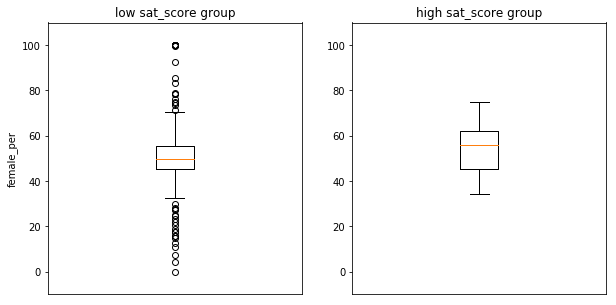

In [22]:
divideAndBoxplot(combined, "sat_score", "female_per", "sat_score")

This seems to show that good gender balance is more likely to be associated with higher SAT scores although not always so.

In [23]:
filterCols([combined["female_per"] > 60, combined["sat_score"] > 1700], ["SchoolName"], df=combined)

/home/gknam/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


,SchoolName
5,0
26,Eleanor Roosevelt High School
60,BEACON SCHOOL
61,FIORELLO H.LAGUARDIA HS
302,TOWNSEND HARRIS HS


According to Wikipedia, these schools are either selective or specialised schools. In other words, they are elite schools. It seems that filtering by top SAT scores tends to leave selective, specialised schools as [already observed](#race_sat_closing).

# Number of Advanced Placement test takers and SAT scores

Intuitively, Advanced Placement (AP) courses are to be taken by academically-high-achieving students. Therefore, it could be suggested that, for each school, more AP test takers could mean higher SAT scores.

To investigate this view, let's see how SAT scores are related with the percentage of AP test takers per school.

Number of data points in the plot: 363
R value: 0.057


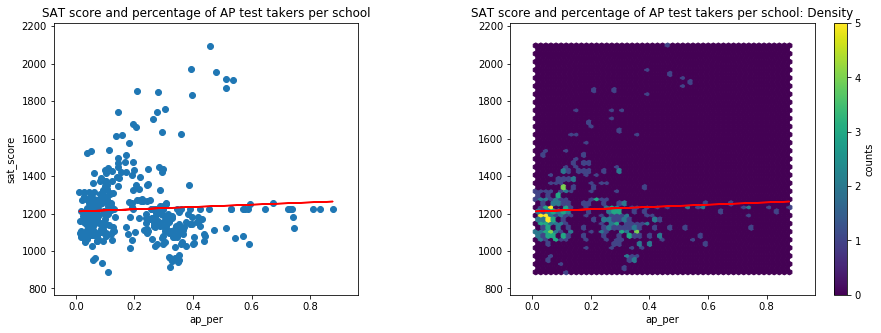

In [24]:
# get percentages of AP test takers per school
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

# scatter plot percentage of AP test takers against SAT score
scatterAndFit("ap_per", "sat_score", "SAT score and percentage of AP test takers per school")

As a whole, there is a very week correlation between SAT scores and the AP test takers' proportions.

However, the lower and higher scoring group display different trends. While the trend in the lower scoring schools generally agreed with the trend of the whole group, the higher scoring schools appear to show a strong correlation between SAT scores and the percentages of AP test takers.

So, let's draw separate scatter plots for high and low SAT scores groups.

High SAT scores group
Number of data points in the plot: 25
R value: 0.824


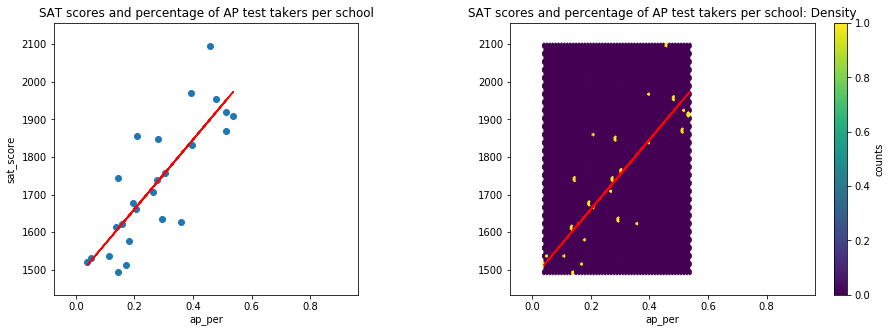


Low SAT scores group
Number of data points in the plot: 338
R value: -0.117


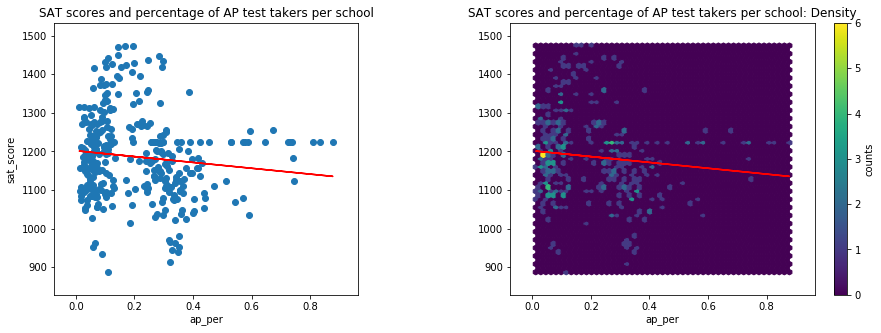

In [25]:
def scatterAndFitHiLo(xCol, yCol_div, xCol_label, yCol_div_label, df=combined):
    """
    df: data frame containing all data
    xCol and yCol_div: columns in data frame
    xCol_label and yCol_div_label: labels to be used in the plot
    
    1. Splits df into high and low yCol_div groups.
    2. Draws scatter plot and regression line using
        df's xCol and yCol_div columns.
    
    Also, get R value (pearson's correlation coeffcient) between
    xCol and yCol_div.

    """
    # split dataset into high and low yCol_div groups
    hi, lo = divideUpperLower(combined, combined[yCol_div])

    # get axis ranges
    xCol_axParam = getMinMaxLeeway(combined[xCol])

    hi_yCol_axParam = getMinMaxLeeway(hi[yCol_div])
    lo_yCol_axParam = getMinMaxLeeway(lo[yCol_div])
    
    # scatter plot yCol_div against xCol
    print("High " + yCol_div_label + " group")
    scatterAndFit(xCol=xCol, yCol=yCol_div, df=hi, \
                  xCol_axParam=xCol_axParam, yCol_axParam=hi_yCol_axParam, \
                 title=yCol_div_label+" and "+xCol_label)

    print("\nLow " + yCol_div_label + " group")
    scatterAndFit(xCol=xCol, yCol=yCol_div, df=lo, \
                  xCol_axParam=xCol_axParam, yCol_axParam=lo_yCol_axParam, \
                 title=yCol_div_label+" and "+xCol_label)

# scatter plot percentage of AP test takers against SAT scores (for high and low SAT score groups)
scatterAndFitHiLo("ap_per", "sat_score", "percentage of AP test takers per school", "SAT scores")

OK, the the high score group is displaying extremely high correlation while the low score group shows a weak negative correlation now, between SAT scores and percentages of AP test takers.

Perhaps this means that high scoring schools select AP test takers more carefully so that their proportion better reflects the schools' levels of performance? But, this is inconclusive due to the shrunk sample size (n=25 in the high score group).

# Further investigation

## Class size and SAT scores

Below are the scatter plots of average class sizes and SAT scores.

Number of data points in the plot: 363
R value: 0.381


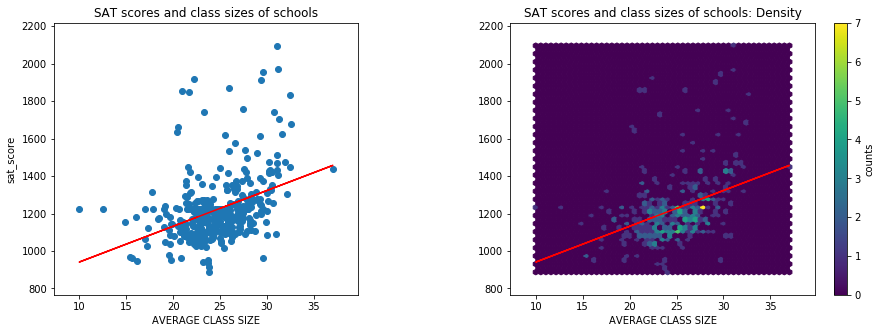

In [26]:
# scatter plot class size against SAT scores
scatterAndFit('AVERAGE CLASS SIZE', 'sat_score', "SAT scores and class sizes of schools")

Generally, class sizes were positively associated with SAT scores. However, upper SAT scorers' data points seem  rather dispersed. So, let's divide them again into upper and lower SAT scores group.

High SAT scores group
Number of data points in the plot: 25
R value: 0.027


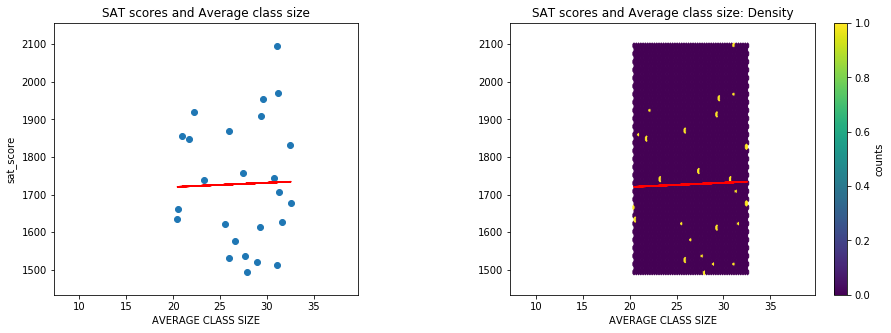


Low SAT scores group
Number of data points in the plot: 338
R value: 0.408


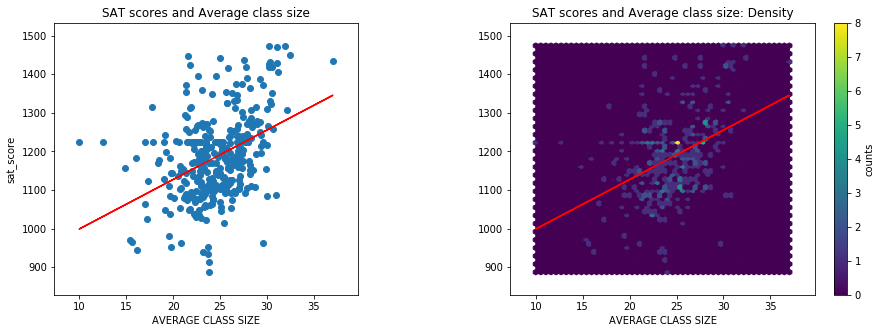

In [27]:
# scatter plot class size against SAT scores (for high and low SAT score groups)
scatterAndFitHiLo("AVERAGE CLASS SIZE", "sat_score", "Average class size", "SAT scores")

OK, so average class size meant much more to the lower SAT scores group.

## Neighbourhoods with highest SAT scores

Anyone with children would be interested in which areas have schools with high SAT scores. So, let's map them.

/home/gknam/Software/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/gknam/Software/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/gknam/Software/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/gknam/Software/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


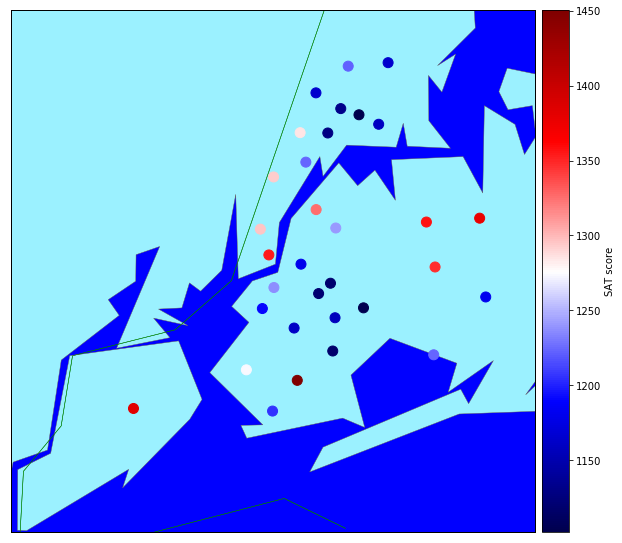

In [28]:
showOnMap(combined_byDist, "sat_score", "SAT score", "dichotomous")

Schools which perform very well at SAT are located in midland Staten Island (1) and Queens (3), Manhattan (4), and South and North of Brooklyn.

## Differences in survey responses among parents, teachers, and students.

Now, let's look at the difference in survey responses among students, parents and teachers.

### Safety score

responder,Parents,Students,Teachers
category,,,
Academic expectations,7.806336,7.381389,7.513499
Communication,7.619559,6.094722,6.528375
Engagement,7.517906,6.620278,0.000000
Safety and respect,8.182920,6.611667,7.144353


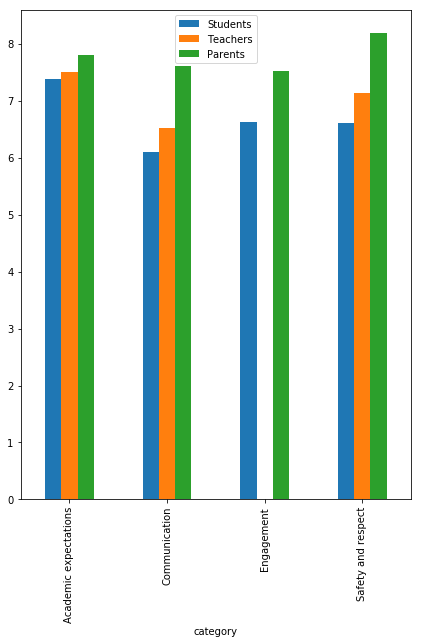

In [30]:
import re
responder = []
category = []
label_map = {"p": "Parents",
            "s": "Students",
            "t": "Teachers",
            "aca": "Academic expectations",
            "com": "Communication",
            "saf": "Safety and respect",
            "eng": "Engagement"}

combined_mean = combined.mean()
for i in combined_mean.index:
    match = re.match("[a-z][a-z][a-z]\_[spt]\_1[0-1]", i)
    if match:
        
        r = re.findall("\_[spt]\_", match.group(0))[0].replace("_", "")
        responder.append(label_map[r])
        
        c = re.sub("\_.*", "", match.group(0))
        category.append(label_map[c])
        
    else:
        responder.append("")
        category.append("")

combined_mean_df = combined_mean.to_frame("combined_mean")
combined_mean_df["responder"] = responder
combined_mean_df["category"] = category
combined_mean_df = combined_mean_df[(combined_mean_df["responder"] != "") & (combined_mean_df["category"] != "")]

combined_mean_df = combined_mean_df.pivot_table(index="category", values="combined_mean", columns="responder")
display(combined_mean_df)
combined_mean_df.sort_values(by="Academic expectations", axis=1).plot(figsize=(7, 9), kind="bar")
plt.legend(loc="best")

plt.show()


Generally, students have the lowest scores while parents' are the hihgest.

### Rating schools

Lastly, I will rate each school based on SAT scores, and safety/respect scores, and list top 20 schools.

The rating will range from 0 to 10.

In [48]:
sat = combined["sat_score"]
safP = combined["saf_p_11"]
safT = combined["saf_t_11"]
safS = combined["saf_s_11"]

max_sat = sat.max()
max_safP = safP.max()
max_safT = safT.max()
max_safS = safS.max()

combined["School rating"] = ((sat + safP + safT + safS) / (max_sat + max_safP + max_safT + max_safS)) * 10

print("Top 20 schools")
display(combined.sort_values(by="School rating", ascending=False)[["School rating", \
                                                                   "DBN", "SchoolName", "borough", \
                                                                   "school_dist"]].head(20))

Top 20 schools


,School rating,DBN,SchoolName,borough,school_dist
37,9.975521,02M475,STUYVESANT HS,Manhattan,02
151,9.373911,10X445,BRONX HS OF SCIENCE,Bronx,10
356,9.315539,31R605,STATEN ISLAND TECHNICAL HS,Staten Island,31
155,9.160665,10X696,HIGH SCHOOL OF AMERICAN STUDIES At Lehman College,Bronx,10
302,9.106529,25Q525,TOWNSEND HARRIS HS,Queens,25
327,8.902697,28Q687,Queens HS for Science York Colllege,Queens,28
5,8.856094,01M696,0,Manhattan,01
79,8.813256,05M692,HIGH SCHOOL FOR MATH SCIENCE ENGINEERING @ CCNY,Manhattan,05
187,8.735583,13K430,BROOKLYN TECHNICAL HS,Brooklyn,13
26,8.394765,02M416,Eleanor Roosevelt High School,Manhattan,02


With this limited criteria, Manhattan is the winner!

# Closing comment

This is a guided project by DataQuest. I generally followed its instructions although I added some bits.

It's important to note that no statstical tests have been carried out in this project, and therefore no views expressed here are statiscally sound.